# Plot Comparison Between Algorithms

Expects the input data to contain CSV files containing episode lengths

In [38]:
import os
import numpy as np

%reload_ext autoreload
%autoreload 2

We need to read the CSV files (from a function in another file) to get the reward at each timestep for each run of each algorithm. Only the `dataPath` will be loaded.

`load_data` loads the CSV files containing episode lengths as a numpy array of Pandas DataFrames.

`dataPath` contains the exact path of the directories containing the CSV files. This path is relative to the `data` directory. It assumes every element will be path for a different algorithm. It will overwrite if two paths are for different parameter settings of the same algorithm.

Expects there to be more than 1 input CSV file.

In [39]:
#dataPath = ['esarsa/alpha-0.015625_driftProb--1,-1,-1,-1_driftScale-1000_enable-debug-0_epsilon-0.05_gamma-0.95_lambda-0.8_sensorLife-1,1,1,1_tiles-4_tilings-32',
#            'dqn/alpha-0.015625_driftProb--1,-1,-1,-1_driftScale-100_enable-debug-0_epsilon-0.05_gamma-0.95_lambda-0.8_sensorLife-1,1,1,1_tiles-4_tilings-32/']
#dataPath = ['esarsa1/adaptive-alpha=3e-06_adaptive-stepsize=1_alpha=0.1_delays=0_enable-debug=0_epsilon=0.1_gamma=0.9_is-stepsize-adaptive=1_lambda=0.7_tiles=8_tilings=32/']

dataPath = ['esarsa1/adaptive-alpha=3e-06_adaptive-stepsize=1_alpha=0.1_delays=0_enable-debug=0_epsilon=0.1_gamma=0.9_is-stepsize-adaptive=1_lambda=0.7_tiles=8_tilings=32/', 'dqn4/alpha=1e-05_buffer-size=2500_buffer-type=random_decreasing-epsilon=None_delays=0_dqn-adamBeta1=0.9_dqn-adamBeta2=0.999_dqn-adamEps=1e-08_dqn-batch=64_dqn-hidden=64,64_dqn-sync=32_enable-debug=0_']

basePath = '../data/'

algorithms = [dataPath[i].split('/')[0] for i in range(len(dataPath))]
    
Data = {}

from loadFromEpisodeLengths import load_data

for i in range(len(dataPath)):
    if os.path.isdir(basePath + dataPath[i]) == True:
        Data[algorithms[i]] = load_data(basePath+dataPath[i])

print('Data will be stored for', ', '.join([k for k in Data.keys()]))
print('Loaded the episode lengths data from the csv files')

Data will be stored for esarsa1, dqn4
Loaded the episode lengths data from the csv files


`convert_data` converts the episode lengths (numpy array of Pandas DataFrames) into the absolute timesteps when failures occur (a python list of Pandas DataFrames)

In [40]:
convertedData = {}

from loadFromEpisodeLengths import convert_data

for alg, data in Data.items():
    convertedData[alg], totalTimesteps = convert_data(alg, data)

print('Data will be stored for', ', '.join([k for k in convertedData.keys()]))
print('The stored episode lengths are converted to absolute failure timesteps')

Data will be stored for esarsa1, dqn4
The stored episode lengths are converted to absolute failure timesteps


The rewards can be transformed into the following values of transformation =
1. 'Returns'
2. 'Failures'
3. 'Average-Rewards'
4. 'Rewards' (no change)

----------------------------------------------------------------------------------------------

There is an additional parameter of window which can be any non-negative integer. It is used for the 'Average-Rewards' transformation to maintain a moving average over a sliding window. By default window is 0.

The type parameter takes in 'sample-averaging' or 'exponential-averaging'.

The parameter alpha takes in a smoothing constant value

- If window is 500 and timesteps are 10000, then the first element is the average of the performances of timesteps from 1 - 500. The second element is the average of the performances of timesteps from 2 - 501. The last element is the average of the performances of timesteps from 9501 - 10000.

----------------------------------------------------------------------------------------------

`transform_data` transforms the absolute failure timesteps (python list of Pandas DataFrames) into the respective `transformation` (a numpy array of numpy arrays) for plotting

In [50]:
plottingData = {}

from loadFromEpisodeLengths import transform_data

transformation = 'Average-Rewards'
window = 2500
alpha = 0.01
averaging_type='exponential-averaging'

for alg, data in convertedData.items():
    plottingData[alg] = transform_data(alg, data, totalTimesteps, transformation, window, type=averaging_type, alpha=alpha)

print('Data will be plotted for', ', '.join([k for k in plottingData.keys()]))
print('The stored failure timesteps are transformed to: ', transformation)

0 esarsa1
10 esarsa1
0 dqn4
10 dqn4
Data will be plotted for esarsa1, dqn4
The stored failure timesteps are transformed to:  Average-Rewards


Here, we can plot the following statistics:

1. Mean of all the runs

2. Median run

3. Run with the best performance (highest return, or equivalently least failures)

4. Run with the worst performance (lowest return, or equivalently most failures)

5. Mean along with the confidence interval (Currently, plots the mean along with 95% confidence interval, but should be changed to make it adaptive to any confidence interval)

6. Mean along with percentile regions (Plots the mean and shades the region between the run with the lower percentile and the run with the upper percentile)

----------------------------------------------------------------------------------------------

Details:

plotBest, plotWorst, plotMeanAndPercentileRegions sort the performances based on their final performance

                                   ----------------------------------------------------

Mean, Median, MeanAndConfidenceInterval are all symmetric plots so 'Failures' does not affect their plots
    
Best, Worst, MeanAndPercentileRegions are all asymmetric plots so 'Failures' affects their plots, and has to be treated in the following way:   

                                   ----------------------------------------------------

1. plotBest for Returns will plot the run with the highest return (least failures)
   plotBest for Failures will plot the run with the least failures and not the highest failures

2. plotWorst for Returns will plot the run with the lowest return (most failures)
   plotWorst for Failures will plot the run with the most failures and not the least failures

3. plotMeanAndPercentileRegions for Returns uses the lower variable to select the run with the 'lower' percentile and uses the upper variable to select the run with the 'upper' percentile
   plotMeanAndPercentileRegions for Failures uses the lower variable along with some calculations to select the run with 'upper' percentile and uses the upper variable along with some calculations to select the run with the 'lower' percentile 
    
----------------------------------------------------------------------------------------------

Caution:
- Jupyter notebooks (mostly) or matplotlib gives an error when displaying very dense plots. For example: plotting best and worst case for transformation of 'Rewards' for 'example' algorithm, or when trying to zoom into dense plots. Most of the plots for 'Rewards' and 'example' fail.

In [51]:
from stats import getMean, getMedian, getBest, getWorst, getConfidenceIntervalOfMean, getRegion

# Add color, linestyles as needed

def plotMean(xAxis, data, color):
    mean = getMean(data)
    plt.plot(xAxis, mean, label=alg+'-mean', color=color)

def plotMedian(xAxis, data, color):
    median = getMedian(data)
    plt.plot(xAxis, median, label=alg+'-median', color=color)

def plotBest(xAxis, data, transformation, color):
    best = getBest(data, transformation)
    plt.plot(xAxis, best, label=alg+'-best', color=color)

def plotWorst(xAxis, data, transformation, color):
    worst = getWorst(data,  transformation)
    plt.plot(xAxis, worst, label=alg+'-worst', color=color)

def plotMeanAndConfidenceInterval(xAxis, data, confidence, color):
    plotMean(xAxis, data, color=color)
    lowerBound, upperBound = getConfidenceIntervalOfMean(data, confidence)
    plt.fill_between(xAxis, lowerBound, upperBound, alpha=0.25, color=color)

def plotMeanAndPercentileRegions(xAxis, data, lower, upper, transformation, color):
    plotMean(xAxis, data, color)
    lowerRun, upperRun = getRegion(data, lower, upper, transformation)
    plt.fill_between(xAxis, lowerRun, upperRun, alpha=0.25, color=color)

Details:

- X axis for 'Average-Rewards' will start from 'window' timesteps and end with the final timesteps

- Need to add color (shades), linestyle as per requirements

- Currently plot one at a time by commenting out the others otherwise, it displays different colors for all.


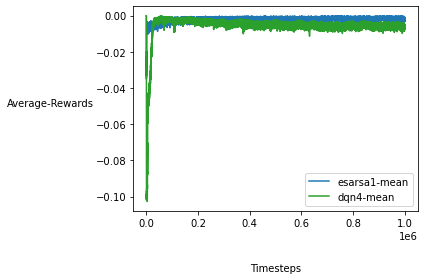

In [52]:
# For saving figures
%matplotlib inline

# For plotting in the jupyter notebook
#%matplotlib notebook         

import matplotlib.pyplot as plt

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

for alg, data in plottingData.items():
    lenRun = len(data[0][:1000000])
    xAxis = np.array([i for i in range(1,lenRun+1)])
    
    if transformation == 'Average-Rewards' and type == 'sample-averaging':
        xAxis += (window-1)
    
    if 'esarsa' in alg:
        color = colors[0]
    elif 'hand' in alg:
        color = colors[1]
    elif 'dqn' in alg:
        color = colors[2]
    
    data = data[:,:1000000]
    
    plotMean(xAxis, data, color=color)

    #plotMedian(xAxis, data, color=color)
    
    #plotBest(xAxis, data, transformation=transformation, color=color)
    
    #plotWorst(xAxis, data, transformation=transformation, color=color)
    
    #plotMeanAndConfidenceInterval(xAxis, data, confidence=0.95, color=color)
    
    #plotMeanAndPercentileRegions(xAxis, data, lower=0.025, upper=0.975, transformation=transformation, color=color)

    
#plt.title('Rewards averaged with sliding window of 1000 timesteps across 100 runs', pad=25, fontsize=10)
plt.xlabel('Timesteps', labelpad=35)
plt.ylabel(transformation, rotation=0, labelpad=45)
plt.rcParams['figure.figsize'] = [8, 5.33]
plt.legend(loc=0)
plt.yticks()
plt.xticks()
plt.tight_layout()

plt.savefig('../img/comparison-'+str(averaging_type)+'-alpha='+str(alpha)+'-'+str(transformation)+'.png',dpi=500, bbox_inches='tight')